word2vecで小説の浮き沈みを可視化する

In [2]:
from gensim.models.word2vec import Word2Vec as wv
import gensim

In [25]:
import MeCab
import matplotlib.pyplot as plt

word2vecモデルは以下のリンクから使わせていただきました。ありがとうございました。
https://aial.shiroyagi.co.jp/2017/02/japanese-word2vec-model-builder/

In [4]:
model = wv.load('./latest-ja-word2vec-gensim-model/word2vec.gensim.model')

In [5]:
print(len(model.wv["ポジティブ"]))
model.wv['ポジティブ']

50


array([ 0.24595872, -0.20374617,  0.04643076, -0.08370793, -0.00159653,
       -0.1498964 , -0.24985418, -0.27679303,  0.04230654, -0.2103632 ,
        0.19847761, -0.0183036 ,  0.1813651 ,  0.05241806, -0.13604565,
        0.08782653, -0.01765659, -0.15811883, -0.23197378, -0.01800125,
        0.22656697,  0.03348085, -0.05751087, -0.03324316,  0.01043968,
        0.10927296,  0.07482351,  0.0193875 , -0.02678603,  0.03127711,
       -0.01660327,  0.00539502, -0.13747899, -0.04497603, -0.03226609,
        0.1099863 , -0.1909478 ,  0.3321621 ,  0.07847033,  0.08839402,
        0.0976343 ,  0.15204719,  0.02627419,  0.06231925,  0.2672885 ,
        0.1843764 ,  0.06427712,  0.28204063,  0.02015338, -0.04207079],
      dtype=float32)

In [6]:
simile_word = model.wv.most_similar(positive=["ポジティブ"], topn=30)
print(simile_word)

[('ネガティブ', 0.9203234910964966), ('エネルギッシュ', 0.9111075401306152), ('非常識', 0.8973114490509033), ('エキセントリック', 0.8965754508972168), ('ストイック', 0.8952075839042664), ('ポジティヴ', 0.8943831920623779), ('シニカル', 0.8901079297065735), ('エモーショナル', 0.888536810874939), ('アグレッシヴ', 0.8869352340698242), ('支離滅裂', 0.885330319404602), ('サディスティック', 0.8837233781814575), ('細やか', 0.8775897026062012), ('キャッチー', 0.8767151832580566), ('ドラマチック', 0.8752379417419434), ('破天荒', 0.8741315007209778), ('辛らつ', 0.8736476898193359), ('辛辣', 0.8733779788017273), ('下品', 0.873147189617157), ('コケティッシュ', 0.8729583621025085), ('爽やか', 0.8715670108795166), ('低俗', 0.8711273074150085), ('ドラマティック', 0.8703761696815491), ('ロマンチック', 0.8697141408920288), ('温か', 0.8693821430206299), ('スリリング', 0.8690565228462219), ('無茶苦茶', 0.868104100227356), ('骨太', 0.8679275512695312), ('デリケート', 0.866979718208313), ('パワフル', 0.8662260174751282), ('大袈裟', 0.8660604953765869)]


In [7]:
similarity = model.wv.similarity(w1="悲しみ", w2="素晴らしい")
print(similarity)

0.47159627


In [8]:
similarity2 = model.wv.similarity(w1="喜び", w2="素晴らしい")
print(similarity2)

0.60737073


In [9]:
with open('./machi.txt',encoding='utf-8') as input_file:
    sentences = input_file.readlines()
    sentences = ''.join(sentences)
sentence_array = ''
sentence_list = []
for sentence in sentences:
    if sentence == '。':
        #print(sentence)
        sentence_list.append(sentence_array)
        #print(sentence_array)
        sentence_array = ''
    else:
        sentence_array += sentence
    #print(sentence_array)

sentence_list = list(map(lambda x:x.strip().replace('\u3000','').replace('\n',''),sentence_list))
#sentence_list = list(map(lambda x :x.replace('\u3000','',inplace=True),sentence_list))
print(sentence_list)

['ひどく寒い日でした', '雪も降っており、すっかり暗くなり、もう夜 ―― 今年さいごの夜でした', 'この寒さと暗闇の中、一人のあわれな少女が道を歩いておりました', '頭に何もかぶらず、足に何もはいていません', '家を出るときには靴をはいていました', 'ええ、確かにはいていたんです', 'でも、靴は何の役にも立ちませんでした', 'それはとても大きな靴で、 これまで少女のお母さんがはいていたものでした', 'たいそう大きい靴でした', 'かわいそうに、道を大急ぎで渡ったとき、少女はその靴をなくしてしまいました', '二台の馬車が猛スピードで走ってきたからです', '片方の靴はどこにも見つかりませんでした', 'もう片方は浮浪児が見つけ、走ってそれを持っていってしまいました', 'その浮浪児は、いつか自分に子どもができたらゆりかごにできると思ったのです', 'それで少女は小さな裸の足で歩いていきました', '両足は冷たさのためとても赤く、また青くなっておりました', '少女は古いエプロンの中にたくさんのマッチを入れ、 手に一たば持っていました', '日がな一日、誰も少女から何も買いませんでした', 'わずか一円だって少女にあげる者はおりませんでした', '寒さと空腹で震えながら、 少女は歩き回りました――まさに悲惨を絵に描いたようです', 'かわいそうな子！ひらひらと舞い降りる雪が少女の長くて金色の髪を覆いました', 'その髪は首のまわりに美しくカールして下がっています', 'でも、もちろん、少女はそんなことなんか考えていません', 'どの窓からも蝋燭の輝きが広がり、 鵞鳥を焼いているおいしそうな香りがしました', 'ご存知のように、今日は大みそかです', 'そうです、少女はそのことを考えていたのです', '二つの家が街の一角をなしていました', 'そのうち片方が前にせり出しています', '少女はそこに座って小さくなりました', '引き寄せた少女の小さな足は体にぴったりくっつきましたが、 少女はどんどん寒くなってきました', 'けれど、家に帰るなんて冒険はできません', 'マッチはまったく売れていないし、 たったの一円も持って帰れないからです', 'このまま帰ったら、きっとお父さんにぶたれてしまいます', 'それに家だって寒いんです', '大きなひび割れだけ

In [36]:
t = MeCab.Tagger('-Ochasen')
result = []
results = []
for sentence in sentence_list:
    node = t.parseToNode(sentence)
    while node:
        features = node.feature.split(',')
        if features[0] != 'BOS/EOS':
            if features[0] not in ['助詞','助動詞','記号']:
                token = features[6] if features[6] != '*' else node.surface
                result.append(token)
        node = node.next
    results.append(result)
    result = []
ans_list = []
for result in results:
    vec_sum = 0
    for word in result:
        try:
            simile = model.wv.similarity(w1="悲しみ", w2=word)
            vec_sum += simile*100
        except KeyError:#学習モデルの中に入っていない語彙
            pass
    ans = vec_sum/len(result)
    ans = round(ans,3)
    ans_list.append(ans)
    ans = 0

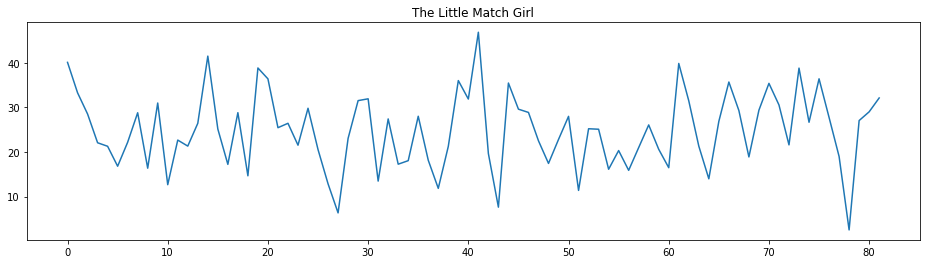

In [42]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,1,1,title='The Little Match Girl')
ax.plot(ans_list)
plt.show()

In [44]:
for i,sentence in enumerate(sentence_list):
    print(i,sentence)

0 ひどく寒い日でした
1 雪も降っており、すっかり暗くなり、もう夜 ―― 今年さいごの夜でした
2 この寒さと暗闇の中、一人のあわれな少女が道を歩いておりました
3 頭に何もかぶらず、足に何もはいていません
4 家を出るときには靴をはいていました
5 ええ、確かにはいていたんです
6 でも、靴は何の役にも立ちませんでした
7 それはとても大きな靴で、 これまで少女のお母さんがはいていたものでした
8 たいそう大きい靴でした
9 かわいそうに、道を大急ぎで渡ったとき、少女はその靴をなくしてしまいました
10 二台の馬車が猛スピードで走ってきたからです
11 片方の靴はどこにも見つかりませんでした
12 もう片方は浮浪児が見つけ、走ってそれを持っていってしまいました
13 その浮浪児は、いつか自分に子どもができたらゆりかごにできると思ったのです
14 それで少女は小さな裸の足で歩いていきました
15 両足は冷たさのためとても赤く、また青くなっておりました
16 少女は古いエプロンの中にたくさんのマッチを入れ、 手に一たば持っていました
17 日がな一日、誰も少女から何も買いませんでした
18 わずか一円だって少女にあげる者はおりませんでした
19 寒さと空腹で震えながら、 少女は歩き回りました――まさに悲惨を絵に描いたようです
20 かわいそうな子！ひらひらと舞い降りる雪が少女の長くて金色の髪を覆いました
21 その髪は首のまわりに美しくカールして下がっています
22 でも、もちろん、少女はそんなことなんか考えていません
23 どの窓からも蝋燭の輝きが広がり、 鵞鳥を焼いているおいしそうな香りがしました
24 ご存知のように、今日は大みそかです
25 そうです、少女はそのことを考えていたのです
26 二つの家が街の一角をなしていました
27 そのうち片方が前にせり出しています
28 少女はそこに座って小さくなりました
29 引き寄せた少女の小さな足は体にぴったりくっつきましたが、 少女はどんどん寒くなってきました
30 けれど、家に帰るなんて冒険はできません
31 マッチはまったく売れていないし、 たったの一円も持って帰れないからです
32 このまま帰ったら、きっとお父さんにぶたれてしまいます
33 それに家だって寒いんです
34 大きなひび割れだけは、わらとぼろ切れ

問題点：否定語を認識させたれない→美しいものを見たと考える人は（誰一人いませんでした）が美しいもの見たことになっている

参照：https://qiita.com/kojiko430430/items/55b4e16826705aad6bbb